### IMPORTING LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

In [2]:
dataset = pd.read_csv("COVID_dataset_train.csv")

In [3]:
# replacing NaN in Outbreak_Related with NO 
dataset['Outbreak_Related'] = dataset['Outbreak_Related'].fillna("No") 

# Dropping NaN values in Age_Group, Test_reported_date and specimen_date
dataset = dataset.dropna()

In [4]:
dataset.Accurate_Episode_Date = pd.to_datetime(dataset.Accurate_Episode_Date)
dataset.Case_Reported_Date = pd.to_datetime(dataset.Case_Reported_Date)
dataset.Test_Reported_Date = pd.to_datetime(dataset.Test_Reported_Date)
dataset.Specimen_Date = pd.to_datetime(dataset.Specimen_Date)

dataset = dataset.drop(['Test_Reported_Date', 'Specimen_Date'],axis=1)

In [5]:
dataset.Case_Reported_Date = list(map(lambda x: x.timestamp(),dataset.Case_Reported_Date))
dataset.Accurate_Episode_Date = list(map(lambda x: x.timestamp(),dataset.Accurate_Episode_Date))

In [6]:
## encoding of target variable
dataset_target = dataset['Outcome1']
dataset_target = pd.DataFrame(dataset_target, columns = ['Outcome1'])

categorical_cols = ['Outcome1']

# Create the encoder.
encoder_1 = OneHotEncoder(categories = "auto", handle_unknown="error", sparse = False)

# Fit and transform encoder to X
array_hot_encoded_1 = encoder_1.fit_transform(dataset_target)

# convert it to a Data Frame
data_hot_encoded_1 = pd.DataFrame(array_hot_encoded_1, index=dataset_target.index)

# set column names of encoded dataframe
data_hot_encoded_1.columns = encoder_1.get_feature_names(categorical_cols)

dataset_target_1 = data_hot_encoded_1

In [7]:
## encoding of features
dataset_features = dataset.drop(['Outcome1'], axis = 1)

dataset_features['Age_Group'] = dataset_features['Age_Group'].replace({'<20': 1, '20s': 2, '30s': 3 , '40s': 4, '50s': 5, '60s': 6, '70s': 7, '80s': 8, '90s': 9})

categorical_cols = ['Client_Gender','Case_AcquisitionInfo','Reporting_PHU_City','Outbreak_Related']

# Create the encoder.
encoder = OneHotEncoder(categories = "auto", handle_unknown="error", sparse = False)

# Fit and transform encoder to X
array_hot_encoded = encoder.fit_transform(dataset_features[categorical_cols])

# convert it to a Data Frame
data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dataset.index)

# set column names of encoded dataframe
data_hot_encoded.columns = encoder.get_feature_names(categorical_cols)

# concatenate other columns with the encoded columns to get the final datset
data_other_cols = dataset_features.drop(columns=categorical_cols)
dataset_temp = pd.concat([data_hot_encoded, data_other_cols], axis=1)
dataset_features = dataset_temp

In [8]:
X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_target_1, test_size = 0.10)

In [9]:
# X_train = dataset_features
# y_train = dataset_target_1

In [10]:
from sklearn.preprocessing import StandardScaler
numeric_columns = ['Reporting_PHU_Longitude', 'Reporting_PHU_Latitude','Case_Reported_Date', 'Accurate_Episode_Date']

sc = StandardScaler()

X_train_scaled = X_train.copy()


X_train_scaled[numeric_columns] = sc.fit_transform(X_train[numeric_columns])


In [11]:
X_test_scaled = X_test.copy()
X_test_scaled[numeric_columns] = sc.transform(X_test[numeric_columns])

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow as tf

# INITIALING ANN
ann = tf.keras.models.Sequential()

# ADDING INPUT LAYER AND FIRST HIDDEN LAYER
ann.add(tf.keras.layers.Dense(units = 112, activation='relu'))
ann.add(Dropout(0.05))

# ADDING SECOND HIDDEN LAYER
ann.add(tf.keras.layers.Dense(units=448, activation='relu', kernel_regularizer=l2(0.001)))

# ADDING THIRD HIDDEN LAYER
ann.add(tf.keras.layers.Dense(units=56, activation='relu'))

# ADDING OUTPUT LAYER
ann.add(tf.keras.layers.Dense(units=3, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

ann.compile(optimizer=opt , loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience = 10)

fitted_model = ann.fit(X_train_scaled, y_train, validation_split = 0.15, callbacks = [callback], epochs= 400, verbose=1)

Epoch 1/400

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

351/351 [==============================] - 1s 2ms/step - loss: 0.5611 - accuracy: 0.8164 - val_loss: 0.3840 - val_accuracy: 0.8943
Epoch 2/400
351/351 [==============================] - 0s 1ms/step - loss: 0.3930 - accuracy: 0.8766 - val_loss: 0.3402 - val_accuracy: 0.8948
Epoch 3/400
351/351 [==============================] - 0s 1ms/step - loss: 0.3500 - accuracy: 0.8874 - val_loss: 0.3376 - val_accuracy: 0.8923
Epoch 4/400
351/351 [==============================] - 0s 1ms/step - loss: 0.32

In [14]:
ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 112)               5824      
_________________________________________________________________
dropout (Dropout)            (None, 112)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 448)               50624     
_________________________________________________________________
dense_2 (Dense)              (None, 56)                25144     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 171       
Total params: 81,763
Trainable params: 81,763
Non-trainable params: 0
_________________________________________________________________


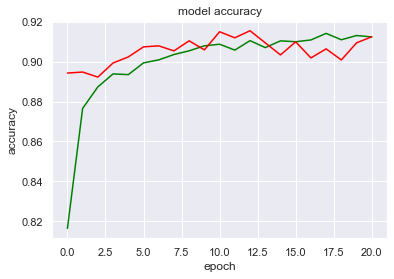

In [15]:
# summarize history for accuracy
plt.plot(fitted_model.history['accuracy'], c = 'green', label = 'acc')
plt.plot(fitted_model.history['val_accuracy'], c = 'red', label = 'val_acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

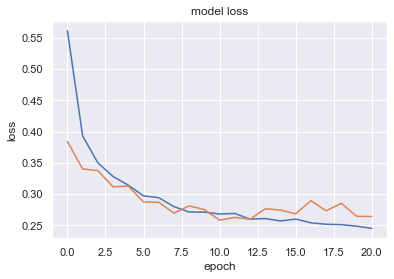

In [16]:
# summarize history for loss
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [17]:
print("Max val acc:", max(fitted_model.history['val_accuracy']))
print("Min val loss:", min(fitted_model.history['val_loss']))
print("Max train acc:", max(fitted_model.history['accuracy']))
print("Min train loss:", min(fitted_model.history['loss']))

Max val acc: 0.9155712723731995
Min val loss: 0.25838324427604675
Max train acc: 0.9142500162124634
Min train loss: 0.2451665997505188


In [18]:
# FOR TESTING ON TRAINING SET

# check test set accuracy
results_train = ann.predict(X_test_scaled)

pred_values_train= []
for result in results_train:
    entry = [0,0,0]
    index = result.argmax()
    entry[index] = 1
    pred_values_train.append(entry)
    
from sklearn.metrics import confusion_matrix, accuracy_score
score = accuracy_score(y_test, pred_values_train)
print("test accuracy for model 1: ", score)

test accuracy for model 1:  0.9180887372013652


### MODEL 2 ---- RMS prop

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow as tf

# INITIALING ANN
ann_2 = tf.keras.models.Sequential()

# ADDING INPUT LAYER AND FIRST HIDDEN LAYER
ann_2.add(tf.keras.layers.Dense(units = 112, activation='relu'))
ann_2.add(Dropout(0.05))

# ADDING SECOND HIDDEN LAYER
ann_2.add(tf.keras.layers.Dense(units=448, activation='relu', kernel_regularizer=l2(0.001)))

# ADDING THIRD HIDDEN LAYER
ann_2.add(tf.keras.layers.Dense(units=56, activation='relu'))

# ADDING OUTPUT LAYER
ann_2.add(tf.keras.layers.Dense(units=3, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.005)

ann_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience = 10)

fitted_model_2 = ann_2.fit(X_train_scaled, y_train, validation_split = 0.15, callbacks = [callback], epochs= 400, verbose=1)

Epoch 1/400

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

351/351 [==============================] - 1s 1ms/step - loss: 0.4773 - accuracy: 0.8347 - val_loss: 0.3296 - val_accuracy: 0.8994
Epoch 2/400
351/351 [==============================] - 0s 1ms/step - loss: 0.3495 - accuracy: 0.8800 - val_loss: 0.3052 - val_accuracy: 0.8989
Epoch 3/400
351/351 [==============================] - 0s 1ms/step - loss: 0.3182 - accuracy: 0.8898 - val_loss: 0.2900 - val_accuracy: 0.9044
Epoch 4/400
351/351 [==============================] - 1s 2ms/step - loss: 0.30

In [21]:
ann_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 112)               5824      
_________________________________________________________________
dropout_1 (Dropout)          (None, 112)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 448)               50624     
_________________________________________________________________
dense_6 (Dense)              (None, 56)                25144     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 171       
Total params: 81,763
Trainable params: 81,763
Non-trainable params: 0
_________________________________________________________________


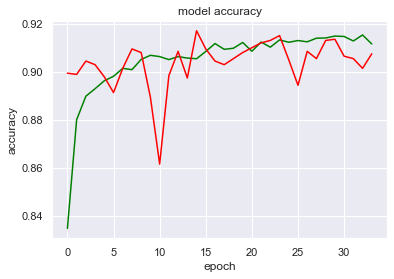

In [22]:
# summarize history for accuracy
plt.plot(fitted_model_2.history['accuracy'], c = 'green', label = 'acc')
plt.plot(fitted_model_2.history['val_accuracy'], c = 'red', label = 'val_acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

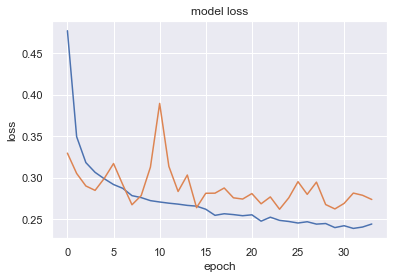

In [23]:
# summarize history for loss
plt.plot(fitted_model_2.history['loss'])
plt.plot(fitted_model_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [24]:
print("Max val acc:", max(fitted_model_2.history['val_accuracy']))
print("Min val loss:", min(fitted_model_2.history['val_loss']))
print("Max train acc:", max(fitted_model_2.history['accuracy']))
print("Min train loss:", min(fitted_model_2.history['loss']))

Max val acc: 0.917087972164154
Min val loss: 0.2619691789150238
Max train acc: 0.9153207540512085
Min train loss: 0.23883534967899323


In [25]:
# FOR TESTING ON TRAINING SET

# check test set accuracy
results_train = ann_2.predict(X_test_scaled)

pred_values_train= []
for result in results_train:
    entry = [0,0,0]
    index = result.argmax()
    entry[index] = 1
    pred_values_train.append(entry)
    
score = accuracy_score(y_test, pred_values_train)
print("test accuracy for model 2: ", score)

test accuracy for model 2:  0.9064846416382253


### MODEL 3

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow as tf

# INITIALING ANN
ann_3 = tf.keras.models.Sequential()

# ADDING INPUT LAYER AND FIRST HIDDEN LAYER
ann_3.add(tf.keras.layers.Dense(units = 112, activation='relu'))
ann_3.add(Dropout(0.05))

# ADDING SECOND HIDDEN LAYER
ann_3.add(tf.keras.layers.Dense(units=448, activation='relu', kernel_regularizer=l2(0.001)))

# ADDING THIRD HIDDEN LAYER
ann_3.add(tf.keras.layers.Dense(units=56, activation='relu'))

# ADDING OUTPUT LAYER
ann_3.add(tf.keras.layers.Dense(units=3, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.01)

ann_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience = 10)

fitted_model_31 = ann_3.fit(X_train_scaled, y_train, validation_split = 0.15, callbacks = [callback], epochs= 400, verbose=1)

Epoch 1/400

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

351/351 [==============================] - 1s 2ms/step - loss: 0.4794 - accuracy: 0.8353 - val_loss: 0.3428 - val_accuracy: 0.8943
Epoch 2/400
351/351 [==============================] - 0s 1ms/step - loss: 0.3397 - accuracy: 0.8822 - val_loss: 0.3020 - val_accuracy: 0.9009
Epoch 3/400
351/351 [==============================] - 0s 1ms/step - loss: 0.3270 - accuracy: 0.8833 - val_loss: 0.3224 - val_accuracy: 0.8959
Epoch 4/400
351/351 [==============================] - 0s 1ms/step - loss: 0.30

In [28]:
ann_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 112)               5824      
_________________________________________________________________
dropout_2 (Dropout)          (None, 112)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 448)               50624     
_________________________________________________________________
dense_10 (Dense)             (None, 56)                25144     
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 171       
Total params: 81,763
Trainable params: 81,763
Non-trainable params: 0
_________________________________________________________________


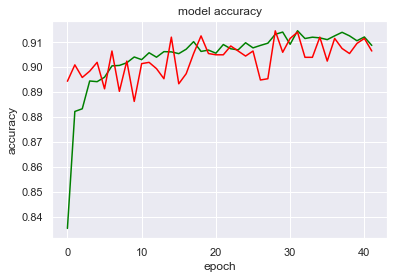

In [29]:
# summarize history for accuracy
plt.plot(fitted_model_31.history['accuracy'], c = 'green', label = 'acc')
plt.plot(fitted_model_31.history['val_accuracy'], c = 'red', label = 'val_acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

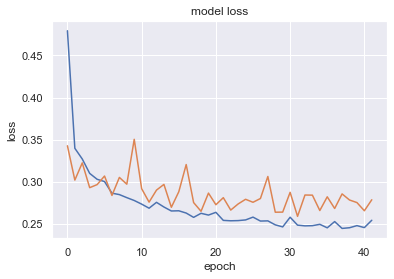

In [30]:
# summarize history for loss
plt.plot(fitted_model_31.history['loss'])
plt.plot(fitted_model_31.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [31]:
print("Max val acc:", max(fitted_model_31.history['val_accuracy']))
print("Min val loss:", min(fitted_model_31.history['val_loss']))
print("Max train acc:", max(fitted_model_31.history['accuracy']))
print("Min train loss:", min(fitted_model_31.history['loss']))

Max val acc: 0.9145601391792297
Min val loss: 0.25890496373176575
Max train acc: 0.9146069288253784
Min train loss: 0.24457155168056488


In [32]:
# FOR TESTING ON TRAINING SET

# check test set accuracy
results_train_31 = ann_3.predict(X_test_scaled)

pred_values_train= []
for result in results_train_31:
    entry = [0,0,0]
    index = result.argmax()
    entry[index] = 1
    pred_values_train.append(entry)
    
score = accuracy_score(y_test, pred_values_train)
print("test accuracy for model 3: ", score)

test accuracy for model 3:  0.9078498293515358


### MODEL 4

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU
leaky_relu = LeakyReLU(alpha=0.01)

# INITIALING ANN
ann_4 = tf.keras.models.Sequential()

# ADDING INPUT LAYER AND FIRST HIDDEN LAYER
ann_4.add(tf.keras.layers.Dense(units = 112, activation = 'relu'))
ann_4.add(Dropout(0.05))

# ADDING SECOND HIDDEN LAYER
ann_4.add(tf.keras.layers.Dense(units=448, activation = 'relu', kernel_regularizer=l2(0.001)))

# ADDING THIRD HIDDEN LAYER
ann_4.add(tf.keras.layers.Dense(units=56, activation = 'relu'))

# ADDING OUTPUT LAYER
ann_4.add(tf.keras.layers.Dense(units=3, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.05)

ann_4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience = 10)

fitted_model_4 = ann_4.fit(X_train_scaled, y_train, validation_split = 0.15, callbacks = [callback], epochs= 400, verbose=1)

Epoch 1/400

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

351/351 [==============================] - 1s 2ms/step - loss: 0.7386 - accuracy: 0.7949 - val_loss: 0.3447 - val_accuracy: 0.8797
Epoch 2/400
351/351 [==============================] - 1s 2ms/step - loss: 0.4002 - accuracy: 0.8556 - val_loss: 0.2934 - val_accuracy: 0.9034
Epoch 3/400
351/351 [==============================] - 1s 1ms/step - loss: 0.3723 - accuracy: 0.8654 - val_loss: 0.3038 - val_accuracy: 0.8928
Epoch 4/400
351/351 [==============================] - 0s 1ms/step - loss: 0.35

In [35]:
ann_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 112)               5824      
_________________________________________________________________
dropout_3 (Dropout)          (None, 112)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 448)               50624     
_________________________________________________________________
dense_14 (Dense)             (None, 56)                25144     
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 171       
Total params: 81,763
Trainable params: 81,763
Non-trainable params: 0
_________________________________________________________________


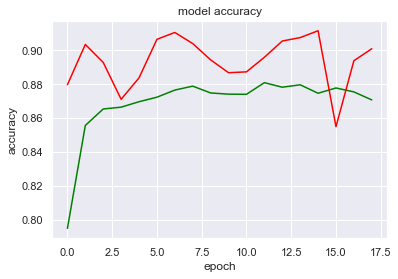

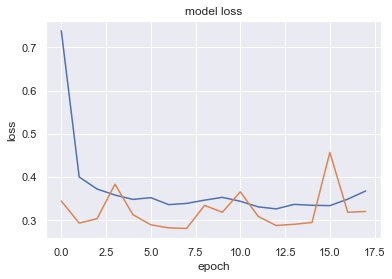

In [36]:
# summarize history for accuracy
plt.plot(fitted_model_4.history['accuracy'], c = 'green', label = 'acc')
plt.plot(fitted_model_4.history['val_accuracy'], c = 'red', label = 'val_acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# summarize history for loss
plt.plot(fitted_model_4.history['loss'])
plt.plot(fitted_model_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [37]:
print("Max val acc:", max(fitted_model_4.history['val_accuracy']))
print("Min val loss:", min(fitted_model_4.history['val_loss']))
print("Max train acc:", max(fitted_model_4.history['accuracy']))
print("Min train loss:", min(fitted_model_4.history['loss']))

Max val acc: 0.9115267992019653
Min val loss: 0.2811967134475708
Max train acc: 0.8808780312538147
Min train loss: 0.32638877630233765


In [38]:
# FOR TESTING ON TRAINING SET

# check test set accuracy
results_train_4 = ann_4.predict(X_test_scaled)

pred_values_train= []
for result in results_train_4:
    entry = [0,0,0]
    index = result.argmax()
    entry[index] = 1
    pred_values_train.append(entry)
    
from sklearn.metrics import confusion_matrix, accuracy_score

score = accuracy_score(y_test, pred_values_train)
print("test accuracy for model 4: ", score)

test accuracy for model 4:  0.8982935153583618


### MODEL 5

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU

# INITIALING ANN
ann_5 = tf.keras.models.Sequential()

# ADDING INPUT LAYER AND FIRST HIDDEN LAYER
ann_5.add(tf.keras.layers.Dense(units = 112, activation = 'relu'))
ann_5.add(Dropout(0.05))

# ADDING SECOND HIDDEN LAYER
ann_5.add(tf.keras.layers.Dense(units=448, activation = 'relu', kernel_regularizer=l2(0.001)))

# ADDING THIRD HIDDEN LAYER
ann_5.add(tf.keras.layers.Dense(units=56, activation = 'relu'))

# ADDING OUTPUT LAYER
ann_5.add(tf.keras.layers.Dense(units=3, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.1)

ann_5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience = 10)

fitted_model_5 = ann_5.fit(X_train_scaled, y_train, validation_split = 0.15, callbacks = [callback], epochs= 400, verbose=1)

Epoch 1/400

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

351/351 [==============================] - 1s 2ms/step - loss: 1.7608 - accuracy: 0.7611 - val_loss: 0.3996 - val_accuracy: 0.8782
Epoch 2/400
351/351 [==============================] - 1s 1ms/step - loss: 0.4524 - accuracy: 0.8464 - val_loss: 0.3603 - val_accuracy: 0.9004
Epoch 3/400
351/351 [==============================] - 1s 2ms/step - loss: 0.4227 - accuracy: 0.8657 - val_loss: 0.3924 - val_accuracy: 0.8726
Epoch 4/400
351/351 [==============================] - 1s 2ms/step - loss: 0.47

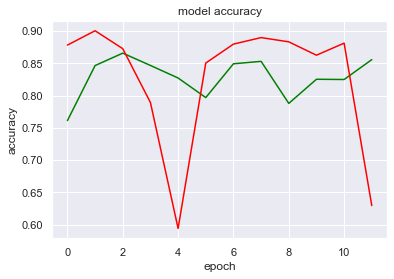

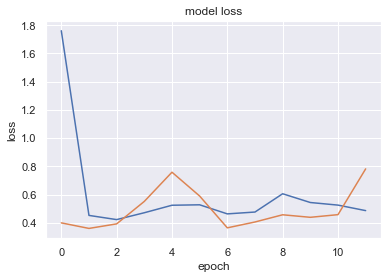

In [41]:
# summarize history for accuracy
plt.plot(fitted_model_5.history['accuracy'], c = 'green', label = 'acc')
plt.plot(fitted_model_5.history['val_accuracy'], c = 'red', label = 'val_acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# summarize history for loss
plt.plot(fitted_model_5.history['loss'])
plt.plot(fitted_model_5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [42]:
print("Max val acc:", max(fitted_model_5.history['val_accuracy']))
print("Min val loss:", min(fitted_model_5.history['val_loss']))
print("Max train acc:", max(fitted_model_5.history['accuracy']))
print("Min train loss:", min(fitted_model_5.history['loss']))

Max val acc: 0.9004044532775879
Min val loss: 0.360276460647583
Max train acc: 0.8657089471817017
Min train loss: 0.42273402214050293


In [43]:
# FOR TESTING ON TRAINING SET

# check test set accuracy
results_train_5 = ann_5.predict(X_test_scaled)

pred_values_train= []
for result in results_train_5:
    entry = [0,0,0]
    index = result.argmax()
    entry[index] = 1
    pred_values_train.append(entry)
    
from sklearn.metrics import confusion_matrix, accuracy_score

score = accuracy_score(y_test, pred_values_train)
print("test accuracy for model 5: ", score)

test accuracy for model 5:  0.6443686006825938


### MODEL 6

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU

# INITIALING ANN
ann_6 = tf.keras.models.Sequential()

# ADDING INPUT LAYER AND FIRST HIDDEN LAYER
ann_6.add(tf.keras.layers.Dense(units = 112, activation='relu'))
ann_6.add(Dropout(0.05))

# ADDING SECOND HIDDEN LAYER
ann_6.add(tf.keras.layers.Dense(units=448, activation='relu', kernel_regularizer=l2(0.001)))

# ADDING THIRD HIDDEN LAYER
ann_6.add(tf.keras.layers.Dense(units=56, activation='relu'))

# ADDING OUTPUT LAYER
ann_6.add(tf.keras.layers.Dense(units=3, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.2)

ann_6.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience = 10)

fitted_model_6 = ann_6.fit(X_train_scaled, y_train, validation_split = 0.15, callbacks = [callback], epochs= 400, verbose=1)

Epoch 1/400

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

351/351 [==============================] - 1s 2ms/step - loss: 7.5860 - accuracy: 0.3402 - val_loss: 1.3434 - val_accuracy: 0.3256
Epoch 2/400
351/351 [==============================] - 0s 1ms/step - loss: 1.1794 - accuracy: 0.3367 - val_loss: 1.1108 - val_accuracy: 0.3256
Epoch 3/400
351/351 [==============================] - 0s 1ms/step - loss: 1.1099 - accuracy: 0.3405 - val_loss: 1.0994 - val_accuracy: 0.3256
Epoch 4/400
351/351 [==============================] - 0s 1ms/step - loss: 1.10

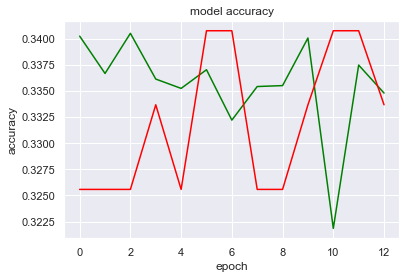

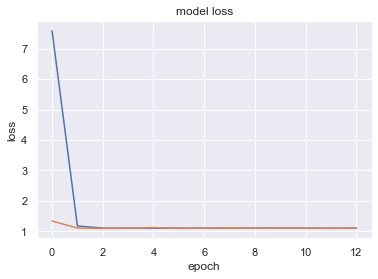

In [46]:
# summarize history for accuracy
plt.plot(fitted_model_6.history['accuracy'], c = 'green', label = 'acc')
plt.plot(fitted_model_6.history['val_accuracy'], c = 'red', label = 'val_acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# summarize history for loss
plt.plot(fitted_model_6.history['loss'])
plt.plot(fitted_model_6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [47]:
print("Max val acc:", max(fitted_model_6.history['val_accuracy']))
print("Min val loss:", min(fitted_model_6.history['val_loss']))
print("Max train acc:", max(fitted_model_6.history['accuracy']))
print("Min train loss:", min(fitted_model_6.history['loss']))

Max val acc: 0.34074822068214417
Min val loss: 1.0993623733520508
Max train acc: 0.34050145745277405
Min train loss: 1.107019066810608


In [48]:
# FOR TESTING ON TRAINING SET

# check test set accuracy
results_train_6 = ann_6.predict(X_test_scaled)

pred_values_train= []
for result in results_train_6:
    entry = [0,0,0]
    index = result.argmax()
    entry[index] = 1
    pred_values_train.append(entry)
    
from sklearn.metrics import confusion_matrix, accuracy_score

score = accuracy_score(y_test, pred_values_train)
print("test accuracy for model 6: ", score)

test accuracy for model 6:  0.3453924914675768
